# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [15]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gmean
import sqlalchemy
import re
import nltk
import time
import pickle
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', 500)

In [2]:
#Downloading nltk packages
nltk.download(['punkt', 'wordnet','stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# load data from database
engine = sqlalchemy.create_engine('sqlite:///messagesDB.db')
df = pd.read_sql_table(table_name='messages', con = engine)
df.describe()


,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.0,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.0,0.063778,0.111497,0.088267,0.015449,0.023039,0.011367,0.033377,0.045545,0.131446,0.065037,0.045812,0.050847,0.020293,0.006065,0.010795,0.004577,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.0,0.244361,0.314752,0.283688,0.123331,0.150031,0.106011,0.179621,0.208500,0.337894,0.246595,0.209081,0.219689,0.141003,0.077643,0.103338,0.067502,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#split dataset in features(X) and target (Y)
X = df['message']
Y = df.iloc[:,4:]

In [6]:
#lets chek columns
Y.columns

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')

### 2. Write a tokenization function to process your text data

In [7]:
def tokenize(text):
    """
    Function to convert message text in tokens
    input:
        text message
    output:
        Remove stop words, numbers and punctuations
        word tokenize, lemmatize
        
    """
    stop_words = set(stopwords.words('english'))     
    
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    # normalize case, remove punctuation and droping numbers
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    text = ''.join((x for x in text if not x.isdigit()))
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

In [8]:
#testing tokenize function how it works
print(X[13])
print(tokenize(X[13]))

Let's do it together, need food in Delma 75, in didine area
['let', 'together', 'need', 'food', 'delma', 'didine', 'area']


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [24]:
#building pipeline
#We will try first with RandomForestClassifier
pipeline = Pipeline([
            ('vect',CountVectorizer(tokenizer=tokenize)),
            ('tfidf',TfidfTransformer()),
            ('clf',MultiOutputClassifier(RandomForestClassifier())),
])


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [25]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [26]:
#train classifier
t1 = time.perf_counter()

pipeline.fit(X_train, y_train)
t2 = time.perf_counter()
print("Finish Training, time:{} mins".format((t2-t1)/60))

Finish Training, time:1.333110748333333 mins


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [27]:
def eval_model(y_test, y_pred, category_names, average_method):
    """    
    Current version sklearn in Udacity workspace is 0.19, since we don't have 
    'output_dict:' parameter, this function will use 'precision_recall_fscore_support' as 
    score(), this function retrieve precision, recall, fscore and support
    
    input
        y_test: array from test split
        y_pred: array predicted
        category_names: category names
    return
        A Dataframe with metrics evaluation for each category
    """
    metrics = []
    for idx, col in enumerate(category_names):
        precision,recall,fscore,support=score(y_test.iloc[:,idx],y_pred[:,idx],average=average_method)
        metrics.append([col,precision,recall,fscore])
    
    return pd.DataFrame(metrics,columns=['Category','Precision','Recall','Fscore'])

def total_eval_mode(df_metrics):
    """
    Print mean evaluation of metrics over all categories
    input:
        DataFrame
    ouput:
        None
    """
    print('Total evaluation over all categories:\n',
      ' Precision: {:.4f}, Recall: {:.4f}, FScore: {:.4f}'.format(df_metrics['Precision'].mean(),
                                                     df_metrics['Recall'].mean(),
                                                     df_metrics['Fscore'].mean()))


In [28]:
#predicting on test data with randomforestclassifer 
y_pred_rf = pipeline.predict(X_test)

In [29]:
#Now we evaluate performance of this model
category_names = Y.columns

df_eval = eval_model(y_test,y_pred_rf, category_names,'macro')
df_eval


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Category,Precision,Recall,Fscore
0,related,0.735007,0.693776,0.709502
1,request,0.829076,0.706004,0.745076
2,offer,0.497864,0.500000,0.498930
3,aid_related,0.749981,0.729747,0.734778
4,medical_help,0.741019,0.546498,0.565059
5,medical_products,0.830124,0.525117,0.535302
6,search_and_rescue,0.673369,0.507586,0.507949
7,security,0.490841,0.499767,0.495264
8,military,0.810393,0.533459,0.553450
9,water,0.888076,0.697860,0.757696


In [30]:
#Printing global performance
total_eval_mode(df_eval)

Total evaluation over all categories:
  Precision: 0.7443, Recall: 0.5843, FScore: 0.6031


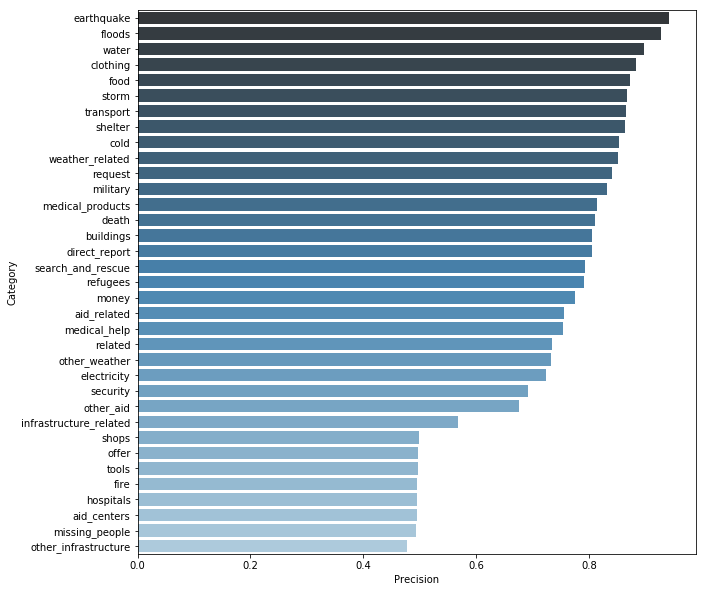

In [15]:
#Plotting precision for each category
plt.figure(figsize = (10,10))
ax = sns.barplot(data = df_eval.sort_values(by='Precision', ascending=False), 
                 x= 'Precision', y = 'Category', palette="Blues_d")


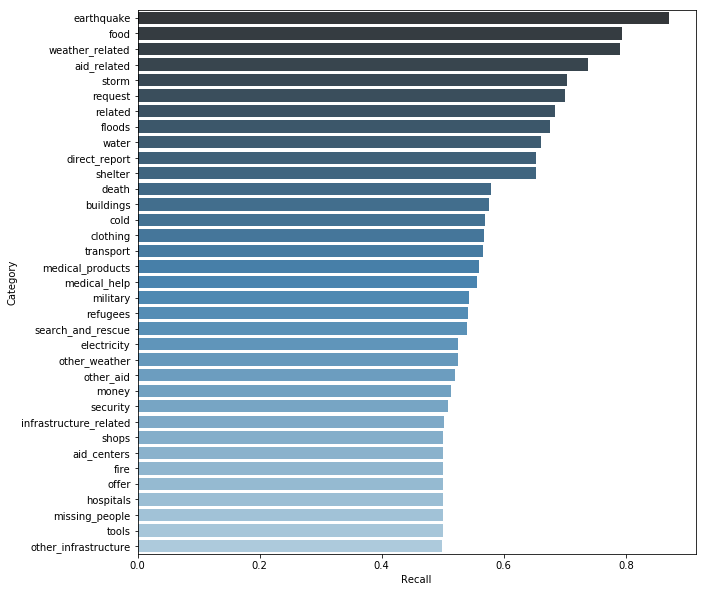

In [16]:
#Plotting Recall for each category
plt.figure(figsize = (10,10))
ax = sns.barplot(data = df_eval.sort_values(by='Recall', ascending=False), 
                 x= 'Recall', y = 'Category', palette="Blues_d")

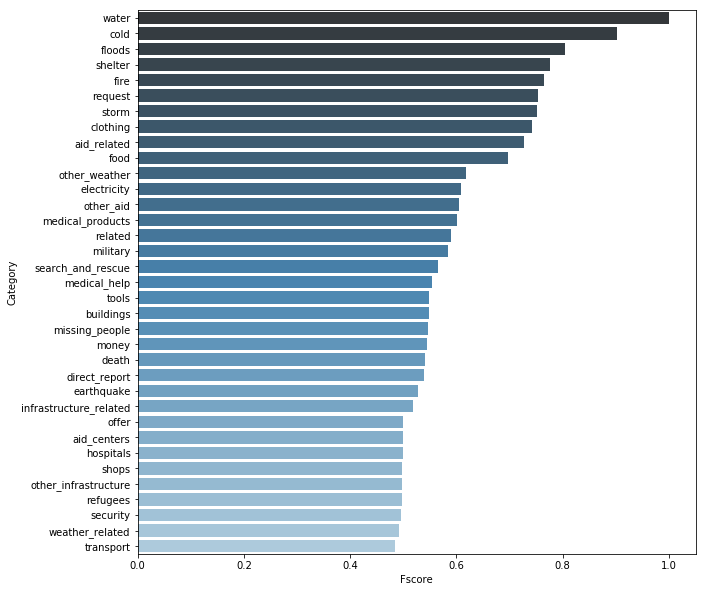

In [21]:
#Plotting F-Score for each category
plt.figure(figsize = (10,10))
ax = sns.barplot(data = df_eval.sort_values(by='Fscore', ascending=False), 
                 x= 'Fscore', y = 'Category', palette="Blues_d")

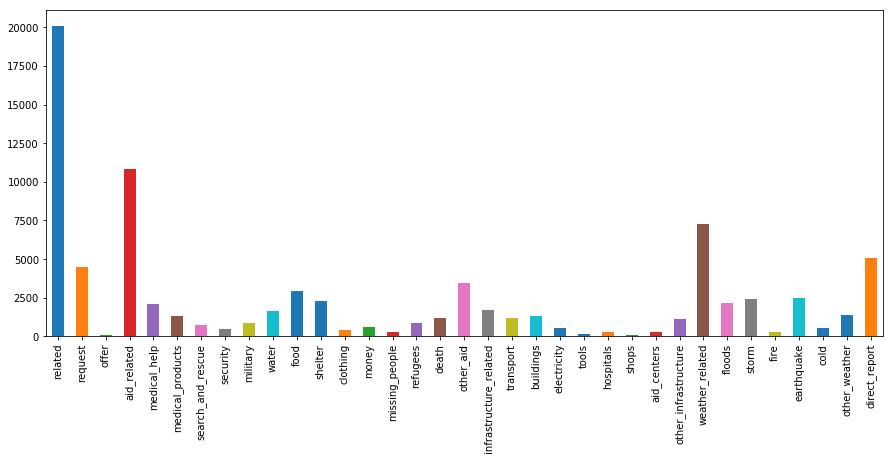

In [17]:
#Lets check how balanced is our data in Y Dataframe
fig = plt.figure(figsize=(15,6))
Y_counts = Y.sum()
Y_counts.plot.bar()
plt.show()

<b> Since the dataset is unbalanced, we will proceed to use the macro average for the model evaluation metrics.Hence the macro-average gives every class the same importance, and therefore better reflects how well the model performs. </b>

### 6. Improve your model
Use grid search to find better parameters. 

In [18]:
#retrieve parameters
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7f863549a0d0>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None,

In [19]:
#Parameters for RandomForestClassifer tunning using first pipeline
parameters = {'vect__max_df': (0.75, 1.0),
              'tfidf__use_idf': (True, False)
             }

cv = GridSearchCV(pipeline,param_grid=parameters, verbose=3, cv = 3)


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [20]:
#RandomForest with tunning

pipeline_rf2 = Pipeline([
            ('vect',CountVectorizer(tokenizer=tokenize)),
            ('tfidf',TfidfTransformer()),
            ('clf',MultiOutputClassifier(RandomForestClassifier())),
])

parameters = {'vect__max_df': (0.75, 1.0),
              'tfidf__use_idf': (True, False)}

cv_rf2 = GridSearchCV(pipeline_rf2,param_grid=parameters, verbose = 3, cv = 3)

t1 = time.perf_counter()
cv.fit(X_train, y_train)

t2 = time.perf_counter()
print("Finish Training, time:{} mins".format((t2-t1)/60))
print("Best parameters:",cv.best_params_)

y_pred_rf2 = cv.predict(X_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] tfidf__use_idf=True, vect__max_df=0.75 ..........................
[CV]  tfidf__use_idf=True, vect__max_df=0.75, score=0.24488861763808362, total=  56.6s
[CV] tfidf__use_idf=True, vect__max_df=0.75 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__max_df=0.75, score=0.2456515105279219, total=  56.8s
[CV] tfidf__use_idf=True, vect__max_df=0.75 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__max_df=0.75, score=0.240311260299054, total=  57.6s
[CV] tfidf__use_idf=True, vect__max_df=1.0 ...........................
[CV]  tfidf__use_idf=True, vect__max_df=1.0, score=0.2511443393347574, total=  57.3s
[CV] tfidf__use_idf=True, vect__max_df=1.0 ...........................
[CV]  tfidf__use_idf=True, vect__max_df=1.0, score=0.252212389380531, total=  57.2s
[CV] tfidf__use_idf=True, vect__max_df=1.0 ...........................
[CV]  tfidf__use_idf=True, vect__max_df=1.0, score=0.2462618248397925, total=  58.0s
[CV] tfidf__use_idf=False, vect__max_df=0.75 .........................
[CV]  tfidf__use_idf=False, vect__max_df=0.75, score=0.2445834604821483, total=  57.7s
[CV] tfidf__use_idf=False, vect__max_df=0.75 .........................
[CV]  tfidf__use_idf=False, vect__max_df=0.75, score=0.24794018919743668, total=  57.6s
[CV] tfidf__use_idf=False, vect__max_df=0.75 .........................
[CV]  tfidf__use_idf=False, vect__max_df=0.75, score=0.24107

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 14.8min finished


Finish Training, time:16.25928293645 mins
Best parameters: {'tfidf__use_idf': True, 'vect__max_df': 1.0}


In [21]:
#Now let's evaluate performance new tunned model with the original randomforestclassifier
df_eval2 = eval_model(y_test,y_pred_rf2, category_names,'macro')
total_eval_mode(df_eval)
total_eval_mode(df_eval2)


Total evaluation over all categories:
  Precision: 0.7333, Recall: 0.5889, FScore: 0.6099
Total evaluation over all categories:
  Precision: 0.7570, Recall: 0.5869, FScore: 0.6084


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


With this tunned model we see some improvement in precision metric, the other ones, not so much.

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

We will using AdaBoosClassifer and GradientBoostClassifer to compare with RandomForest.
We will keep the best scores from these algorithms.

In [22]:
#using AdaBoostClassifer
pipeline_Ada = Pipeline([
            ('vect',CountVectorizer(tokenizer=tokenize)),
            ('tfidf',TfidfTransformer()),
            ('clf',MultiOutputClassifier(AdaBoostClassifier())),
])

parameters = {'vect__max_df': (0.75, 1.0),
              'tfidf__use_idf': (True, False)}

cv_ada = GridSearchCV(pipeline_Ada,param_grid=parameters, verbose = 3, cv = 3)

t1 = time.perf_counter()
cv_ada.fit(X_train, y_train)

t2 = time.perf_counter()
print("Finish Training, time:{} mins".format((t2-t1)/60))
print("Best parameters:",cv_ada.best_params_)

y_pred_ada = cv_ada.predict(X_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] tfidf__use_idf=True, vect__max_df=0.75 ..........................
[CV]  tfidf__use_idf=True, vect__max_df=0.75, score=0.23634421727189503, total= 1.5min
[CV] tfidf__use_idf=True, vect__max_df=0.75 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__max_df=0.75, score=0.2397009459871834, total= 1.5min
[CV] tfidf__use_idf=True, vect__max_df=0.75 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__max_df=0.75, score=0.23100396704302717, total= 1.5min
[CV] tfidf__use_idf=True, vect__max_df=1.0 ...........................
[CV]  tfidf__use_idf=True, vect__max_df=1.0, score=0.2371071101617333, total= 1.5min
[CV] tfidf__use_idf=True, vect__max_df=1.0 ...........................
[CV]  tfidf__use_idf=True, vect__max_df=1.0, score=0.23909063167531278, total= 1.4min
[CV] tfidf__use_idf=True, vect__max_df=1.0 ...........................
[CV]  tfidf__use_idf=True, vect__max_df=1.0, score=0.2308513884650595, total= 1.4min
[CV] tfidf__use_idf=False, vect__max_df=0.75 .........................
[CV]  tfidf__use_idf=False, vect__max_df=0.75, score=0.2422947818126335, total= 1.4min
[CV] tfidf__use_idf=False, vect__max_df=0.75 .........................
[CV]  tfidf__use_idf=False, vect__max_df=0.75, score=0.23237717424473603, total= 1.4min
[CV] tfidf__use_idf=False, vect__max_df=0.75 .........................
[CV]  tfidf__use_idf=False, vect__max_df=0.75, score=0.2

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 20.3min finished


Finish Training, time:22.166832730400007 mins
Best parameters: {'tfidf__use_idf': False, 'vect__max_df': 0.75}


In [23]:
df_eval3 = eval_model(y_test,y_pred_ada, category_names,average_method='macro')
total_eval_mode(df_eval)
total_eval_mode(df_eval3)

Total evaluation over all categories:
  Precision: 0.7333, Recall: 0.5889, FScore: 0.6099
Total evaluation over all categories:
  Precision: 0.7763, Recall: 0.6473, FScore: 0.6793


With Adaboosclassifier we get better results.

In [24]:
#using GradientBoostingClassifier
pipeline_gb = Pipeline([
            ('vect',CountVectorizer(tokenizer=tokenize)),
            ('tfidf',TfidfTransformer()),
            ('clf',MultiOutputClassifier(GradientBoostingClassifier())),
])

parameters = {'vect__max_df': (0.75, 1.0),
              'tfidf__use_idf': (True, False)}

cv_gb = GridSearchCV(pipeline_gb,param_grid=parameters, verbose = 3, cv = 3)

t1 = time.perf_counter()
cv_gb.fit(X_train, y_train)

t2 = time.perf_counter()
print("Finish Training, time:{} mins".format((t2-t1)/60))
print("Best parameters:",cv_gb.best_params_)

y_pred_gb = cv_gb.predict(X_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] tfidf__use_idf=True, vect__max_df=0.75 ..........................
[CV]  tfidf__use_idf=True, vect__max_df=0.75, score=0.23420811718034787, total= 4.3min
[CV] tfidf__use_idf=True, vect__max_df=0.75 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__max_df=0.75, score=0.23588648153799208, total= 4.4min
[CV] tfidf__use_idf=True, vect__max_df=0.75 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.2min remaining:    0.0s


[CV]  tfidf__use_idf=True, vect__max_df=0.75, score=0.2259688739700946, total= 4.4min
[CV] tfidf__use_idf=True, vect__max_df=1.0 ...........................
[CV]  tfidf__use_idf=True, vect__max_df=1.0, score=0.2354287458040891, total= 4.3min
[CV] tfidf__use_idf=True, vect__max_df=1.0 ...........................
[CV]  tfidf__use_idf=True, vect__max_df=1.0, score=0.23634421727189503, total= 4.4min
[CV] tfidf__use_idf=True, vect__max_df=1.0 ...........................
[CV]  tfidf__use_idf=True, vect__max_df=1.0, score=0.2236801953005798, total= 4.5min
[CV] tfidf__use_idf=False, vect__max_df=0.75 .........................
[CV]  tfidf__use_idf=False, vect__max_df=0.75, score=0.23664937442783032, total= 4.0min
[CV] tfidf__use_idf=False, vect__max_df=0.75 .........................
[CV]  tfidf__use_idf=False, vect__max_df=0.75, score=0.23817516020750687, total= 4.0min
[CV] tfidf__use_idf=False, vect__max_df=0.75 .........................
[CV]  tfidf__use_idf=False, vect__max_df=0.75, score=0.2

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 53.0min finished


Finish Training, time:3534.9572431750003 secs
Best parameters: {'tfidf__use_idf': False, 'vect__max_df': 0.75}


In [26]:
df_eval4 = eval_model(y_test,y_pred_gb, category_names,average_method='macro')
total_eval_mode(df_eval)
total_eval_mode(df_eval4)

Total evaluation over all categories:
  Precision: 0.7333, Recall: 0.5889, FScore: 0.6099
Total evaluation over all categories:
  Precision: 0.7486, Recall: 0.6492, FScore: 0.6726


With GradientBoostClassifier we also get better results than the initial RandomForestClassifier.

In [27]:
#Resuming and Printing all scores from 4 models tested
print("RandomForestClassifier:")
total_eval_mode(df_eval)
print("RandomForestClassifier Tunned:")
total_eval_mode(df_eval2)
print("AdaBoostClassifier:")
total_eval_mode(df_eval3)
print("GradientBoostingClassifier:")
total_eval_mode(df_eval4)

RandomForestClassifier:
Total evaluation over all categories:
  Precision: 0.7333, Recall: 0.5889, FScore: 0.6099
RandomForestClassifier Tunned:
Total evaluation over all categories:
  Precision: 0.7570, Recall: 0.5869, FScore: 0.6084
AdaBoostClassifier:
Total evaluation over all categories:
  Precision: 0.7763, Recall: 0.6473, FScore: 0.6793
GradientBoostingClassifier:
Total evaluation over all categories:
  Precision: 0.7486, Recall: 0.6492, FScore: 0.6726


We get the best results with AdaBoostClassifer, we will keep this model for the Web App for the next steps.

### 9. Export your model as a pickle file

In [28]:
#Save the best model --> AdaBoostClassifier
filename = 'classifier.pkl'
pickle.dump(cv_ada, open(filename, 'wb'))

In [101]:
#loading and testing pickle model
pickled_model = pickle.load(open('classifier.pkl', 'rb'))

X_test_pkl = X_test[100:200]

#testing picled model loaded with some subset from test data
test_pkl = pickled_model.predict(X_test_pkl)
X_test_pkl

23940    The people of the Sahara desert feel abandoned...
25544    But in Mozambique, as the international commun...
478      good night please i need to call urgently for ...
15578    However, these aircraft cannot fly in poor wea...
21774    Other major health issues facing the massive d...
17353    The heavy downpour of the last few weeks has t...
3597     LET BE AWARE IN THOSE MOMENTS,WE SHOULD STOP S...
24223    The central unit would have the additional res...
1167     I'd like to have info about us, people in the ...
2255     like myself. I'm hungry and want to kill mysel...
624      3 children my house was destroyed with everyth...
22353    In Satun province, local people on Sarai Islan...
19419    Because the country is so crowded, others find...
17891    Leaflets have been handed out, with pictures o...
19919    Similar problems prevail in other remote and c...
3047     Food is getting very costly in PAP following t...
91       ( im taking a guess at this sorry its a mix of.

In [100]:
#printing how the model predict categories with this test dataset
pd.DataFrame(test_pkl,columns=category_names)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.